In [1]:
import pandas as pd
import seaborn as sns

from s2_analytics import sqlite_import

con, cur = sqlite_import.import_games("logs_ranked/", "/tmp/s2_ranked.sql", period_days=60)

# calculate counts if kills for each date and weapon including rows with 0 values
cur.execute("""
create table weapon_kills_by_date as
    select distinct dw.date,
                    dw.weaponName,
                    sum(iif(timestamp is null, 0, 1)) kills -- count only if not null
    from
        -- all date+weapon combinations
        (select *
         from (select distinct date from event_kill)
                  cross join (select distinct weaponName from event_kill)) dw

        -- join kill events or nulls if nothing found
            left outer join event_kill ek on dw.date = ek.date and dw.weaponName = ek.weaponName

    group by dw.date, dw.weaponName
""")
pass

## Data summary

In [2]:
query = """
select
    datetime(min(id)/1000, 'unixepoch') first_game_start_time,
    datetime(max(id)/1000, 'unixepoch') last_game_start_time,
    count(1) games_count
from game
"""
pd.read_sql_query(query,
                  con)


,first_game_start_time,last_game_start_time,games_count
0,2022-11-14 18:15:21,2023-01-12 22:57:29,712


In [3]:
query = """
select
    playlistCode,
    count(1) games_count
from game group by playlistCode
"""
pd.read_sql_query(query,
                  con)

,playlistCode,games_count
0,CTF-Standard-4,39
1,CTF-Standard-6,668
2,CTF-Standard-8,5


# Weapon usage trends

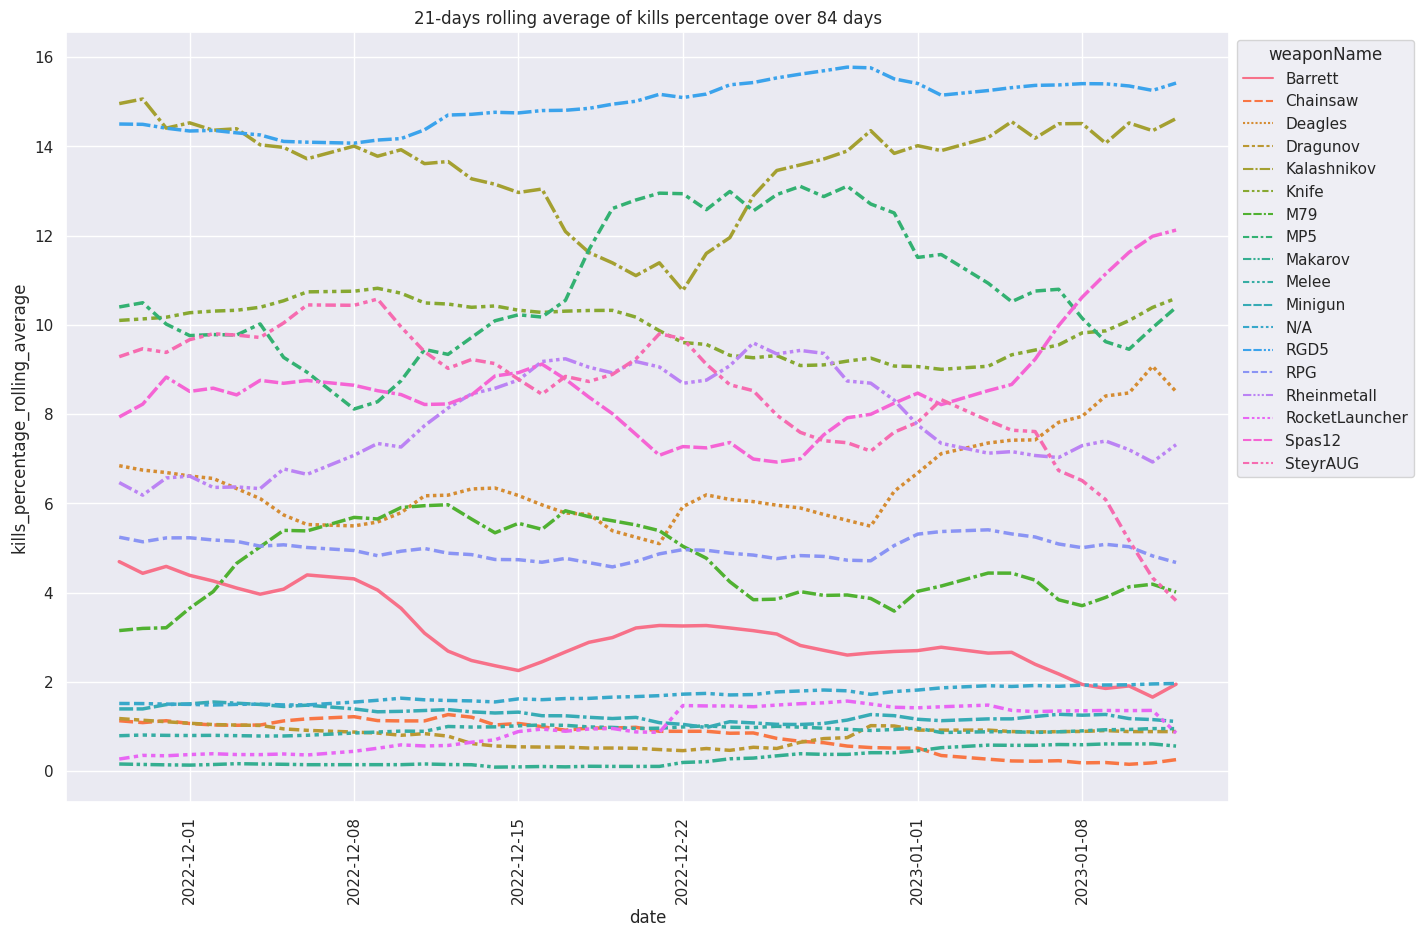

In [4]:

from matplotlib.ticker import FixedLocator


def rolling_average_weapons_used(days: int):
    total_period_days = days * 4
    df = pd.read_sql_query(f"""
    select
        weaponName,
        date,
        100.0 * kills / (select sum(kills) from weapon_kills_by_date wkd2 where wkd.date = wkd2.date) as kills_percentage
    from weapon_kills_by_date wkd
        where date >= datetime('now', '-{total_period_days} days')
    """, con, parse_dates=['date'])
    groupby = df.groupby("weaponName", as_index=False, group_keys=False)

    df["kills_percentage_rolling_average"] = groupby.apply(
        lambda grp, freq: grp.rolling(freq, on='date', min_periods=int(days * 0.75))['kills_percentage'].mean(),
        f"{days}D")

    def generate_rolling_average_plot(df, days: int):
        sns.set(rc={'figure.figsize': (15, 10)})
        plt = sns.lineplot(df, x="date", y=f"kills_percentage_rolling_average",
                           style="weaponName", hue="weaponName", linewidth=2.5)
        plt.xaxis.set_major_locator(FixedLocator(plt.get_xticks().tolist()))
        plt.set_xticklabels(plt.get_xticklabels(), rotation=90)
        plt.set_title(f"{days}-days rolling average of kills percentage over {total_period_days} days")
        sns.move_legend(plt, "upper left", bbox_to_anchor=(1, 1))
        return plt

    generate_rolling_average_plot(df, days)


rolling_average_weapons_used(21)
pass

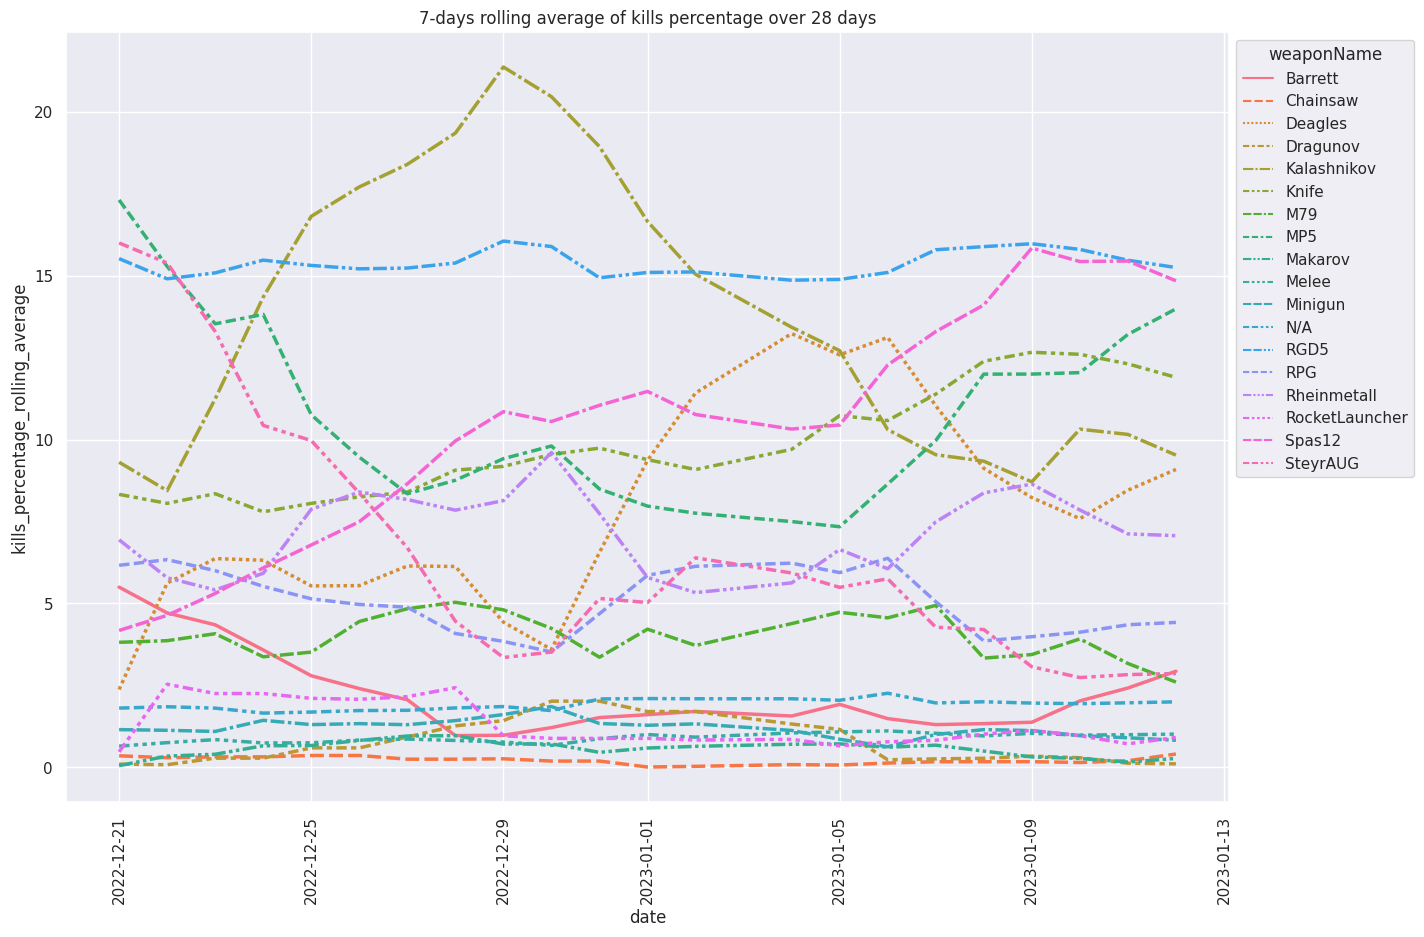

In [5]:
rolling_average_weapons_used(7)

# Kill counts in last 7 days

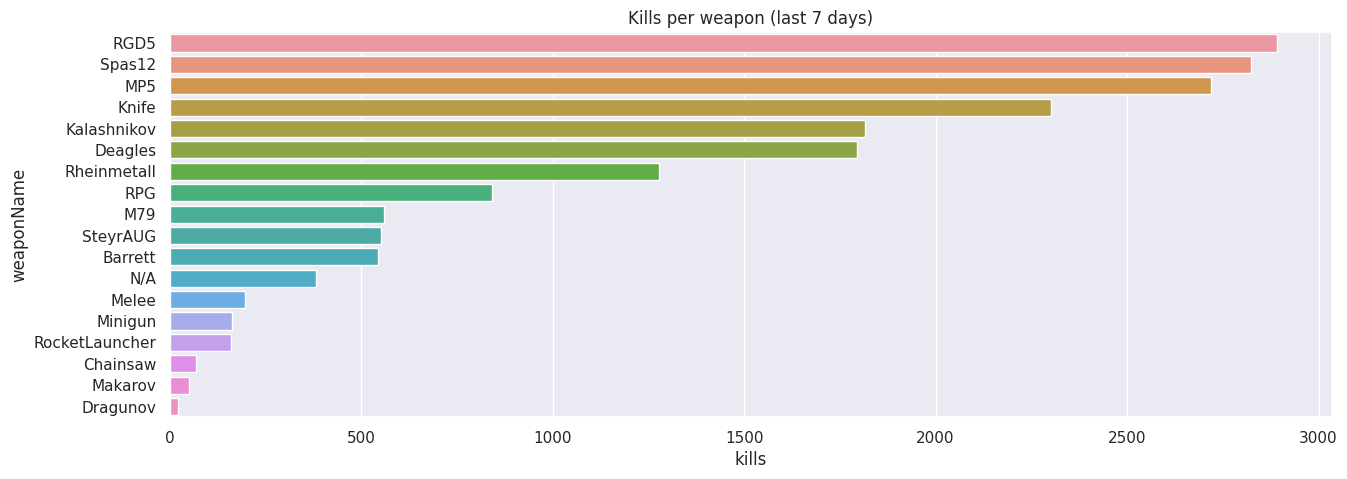

In [6]:
result8 = pd.read_sql_query("""
    select weaponName, count(*) as kills
    from event_kill
    where date >= datetime('now', '-7 day')
    group by weaponName
    order by kills desc
    """, con)
sns.set(rc={'figure.figsize': (15, 5)})
sns.barplot(result8, y="weaponName", x="kills").set(title="Kills per weapon (last 7 days)")
pass